In [89]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM,GRU,Bidirectional
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import keras_tuner as kt
import tensorflow as tf

In [90]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [91]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [92]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [93]:
ticker='TSLA'

In [94]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [95]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [96]:
dates = pd.to_datetime(df['Date'])

In [97]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [98]:
df_for_training = df[cols].astype(float)

In [99]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [100]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [101]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [102]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [103]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [104]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [105]:
size=1125
X_train=X[0:size,:]
X_test=X[size:,:]
y_train=y[0:size,:]
y_test=y[size:,:]


#early stopping


In [106]:
def model_builder(hp):
    model=Sequential()
    model.add(Bidirectional(GRU(128,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=False)))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam',loss='mse')

    return model

In [107]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
tuner = kt.BayesianOptimization(model_builder,
                     objective='val_loss',
                     project_name='gru_tuning',
                     max_trials=51)

Reloading Tuner from ./gru_tuning/tuner0.json


In [108]:
tuner.search(X_train, y_train, epochs=1000, validation_split=0.2, callbacks=[stop_early])


In [109]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first 
layer is {best_hps.get('units')}.
""")


The hyperparameter search is complete. The optimal number of units in the first 
layer is 12.



Epoch 1/1000


4/4 [==============================] - 2s 87ms/step - loss: 0.0748 - val_loss: 0.0088
Epoch 2/1000
4/4 [==============================] - 0s 46ms/step - loss: 0.0051 - val_loss: 0.0131
Epoch 3/1000
4/4 [==============================] - 0s 42ms/step - loss: 0.0238 - val_loss: 0.0068
Epoch 4/1000
4/4 [==============================] - 0s 43ms/step - loss: 0.0096 - val_loss: 0.0040
Epoch 5/1000
4/4 [==============================] - 0s 44ms/step - loss: 0.0023 - val_loss: 0.0116
Epoch 6/1000
4/4 [==============================] - 0s 42ms/step - loss: 0.0037 - val_loss: 0.0122
Epoch 7/1000
4/4 [==============================] - 0s 44ms/step - loss: 0.0027 - val_loss: 0.0065
Epoch 8/1000
4/4 [==============================] - 0s 47ms/step - loss: 0.0010 - val_loss: 0.0030
Epoch 9/1000
4/4 [==============================] - 0s 44ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 10/1000
4/4 [==============================] - 0s 47ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 11/1000
4/4 [===

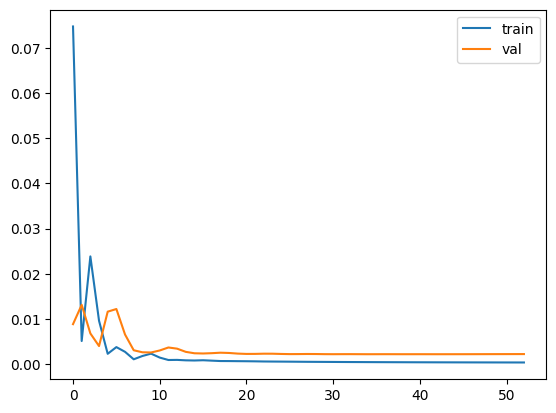

4/4 [==============================] - 0s 4ms/step
mae: 2.7937718051166835


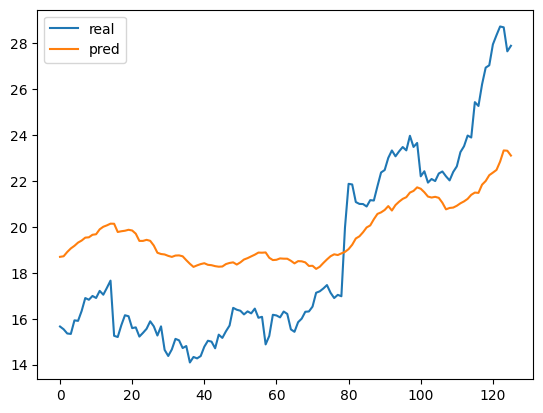

Epoch 1/1000
7/7 [==============================] - 2s 62ms/step - loss: 0.0573 - val_loss: 0.0532
Epoch 2/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0209 - val_loss: 0.0422
Epoch 3/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0083 - val_loss: 0.0094
Epoch 4/1000
7/7 [==============================] - 0s 44ms/step - loss: 0.0079 - val_loss: 0.0086
Epoch 5/1000
7/7 [==============================] - 0s 41ms/step - loss: 0.0039 - val_loss: 0.0174
Epoch 6/1000
7/7 [==============================] - 0s 38ms/step - loss: 0.0031 - val_loss: 0.0190
Epoch 7/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0027 - val_loss: 0.0122
Epoch 8/1000
7/7 [==============================] - 0s 38ms/step - loss: 0.0026 - val_loss: 0.0102
Epoch 9/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0021 - val_loss: 0.0112
Epoch 10/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0018 - val_loss: 0.0094
Epoch 11/

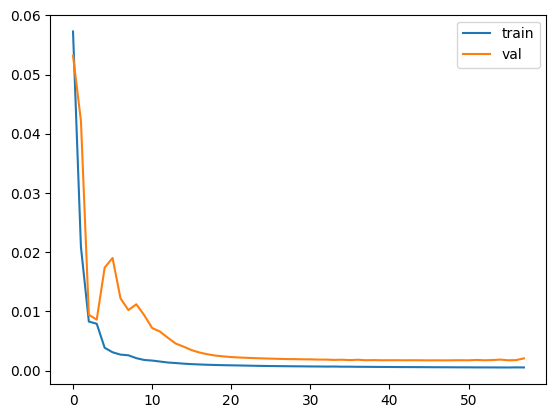

4/4 [==============================] - 0s 5ms/step
mae: 2.0295296273857


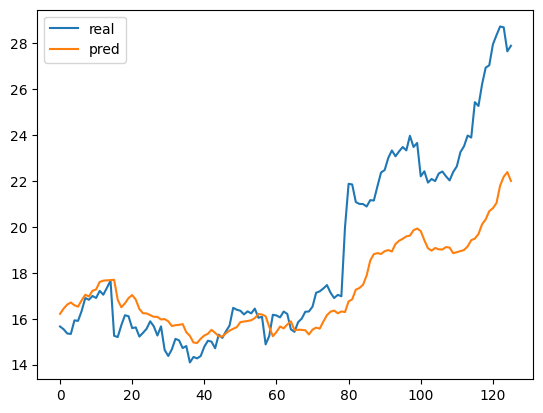

Epoch 1/1000
10/10 [==============================] - 2s 54ms/step - loss: 0.0473 - val_loss: 0.0055
Epoch 2/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.0172 - val_loss: 0.0287
Epoch 3/1000
10/10 [==============================] - 0s 40ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 4/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 5/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - val_loss: 0.0052
Epoch 6/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 7/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 8/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 9/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 10/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - val_lo

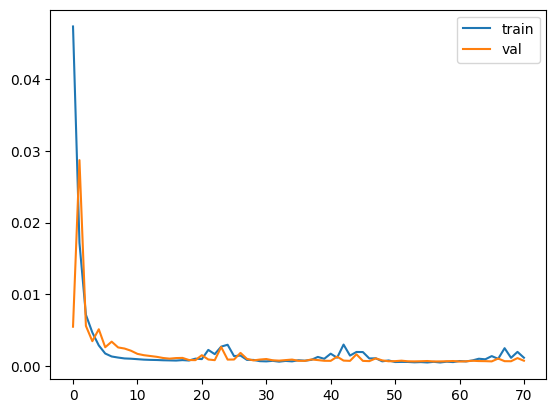

4/4 [==============================] - 0s 4ms/step
mae: 1.8072697480463908


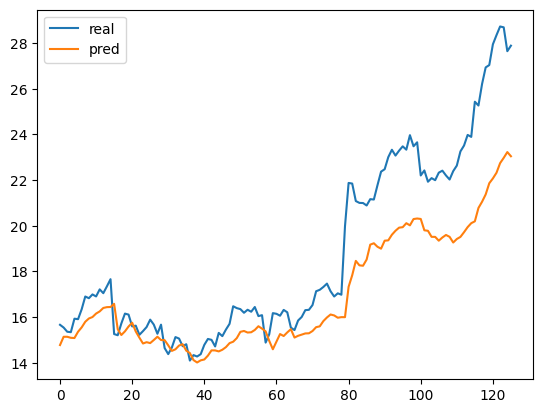

Epoch 1/1000
13/13 [==============================] - 2s 45ms/step - loss: 0.0265 - val_loss: 0.0026
Epoch 2/1000
13/13 [==============================] - 0s 35ms/step - loss: 0.0170 - val_loss: 0.0052
Epoch 3/1000
13/13 [==============================] - 0s 35ms/step - loss: 0.0094 - val_loss: 0.0030
Epoch 4/1000
13/13 [==============================] - 0s 36ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 5/1000
13/13 [==============================] - 0s 34ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 6/1000
13/13 [==============================] - 0s 33ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 7/1000
13/13 [==============================] - 0s 33ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/1000
13/13 [==============================] - 0s 36ms/step - loss: 0.0011 - val_loss: 9.8733e-04
Epoch 9/1000
13/13 [==============================] - 0s 34ms/step - loss: 0.0012 - val_loss: 9.9417e-04
Epoch 10/1000
13/13 [==============================] - 0s 34ms/step - loss: 0.0011 

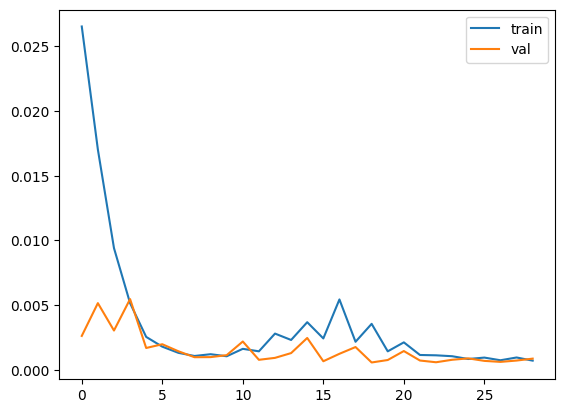

4/4 [==============================] - 0s 4ms/step
mae: 1.5596155445837598


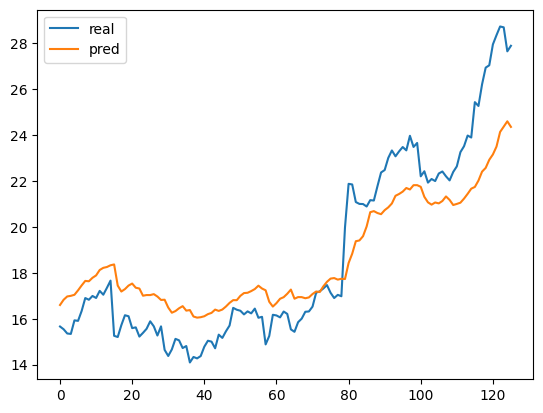

Epoch 1/1000
17/17 [==============================] - 2s 43ms/step - loss: 0.0182 - val_loss: 0.0896
Epoch 2/1000
17/17 [==============================] - 1s 36ms/step - loss: 0.0073 - val_loss: 0.0588
Epoch 3/1000
17/17 [==============================] - 1s 35ms/step - loss: 0.0063 - val_loss: 0.0163
Epoch 4/1000
17/17 [==============================] - 1s 35ms/step - loss: 0.0106 - val_loss: 0.0042
Epoch 5/1000
17/17 [==============================] - 1s 35ms/step - loss: 0.0049 - val_loss: 0.0262
Epoch 6/1000
17/17 [==============================] - 1s 35ms/step - loss: 0.0103 - val_loss: 0.0416
Epoch 7/1000
17/17 [==============================] - 1s 35ms/step - loss: 0.0054 - val_loss: 0.0063
Epoch 8/1000
17/17 [==============================] - 1s 34ms/step - loss: 0.0072 - val_loss: 0.0083
Epoch 9/1000
17/17 [==============================] - 1s 34ms/step - loss: 0.0029 - val_loss: 0.0248
Epoch 10/1000
17/17 [==============================] - 1s 36ms/step - loss: 0.0058 - val_lo

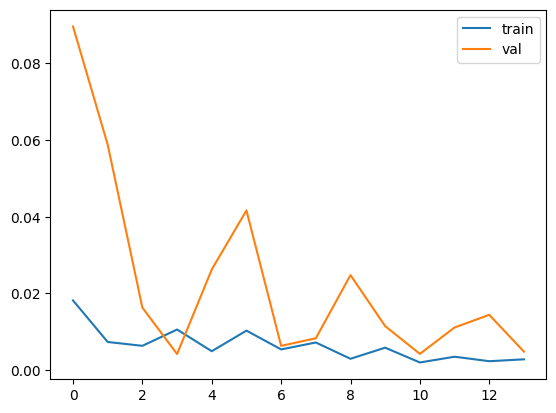

4/4 [==============================] - 0s 4ms/step
mae: 2.0058408365589933


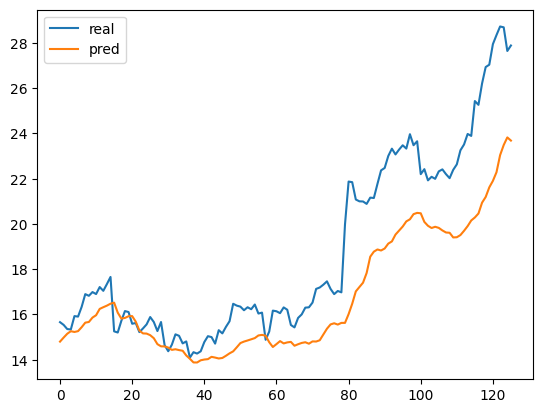

Epoch 1/1000
20/20 [==============================] - 2s 41ms/step - loss: 0.0365 - val_loss: 0.0230
Epoch 2/1000
20/20 [==============================] - 1s 35ms/step - loss: 0.0193 - val_loss: 0.0074
Epoch 3/1000
20/20 [==============================] - 1s 34ms/step - loss: 0.0082 - val_loss: 0.0040
Epoch 4/1000
20/20 [==============================] - 1s 34ms/step - loss: 0.0089 - val_loss: 0.0182
Epoch 5/1000
20/20 [==============================] - 1s 34ms/step - loss: 0.0108 - val_loss: 0.0035
Epoch 6/1000
20/20 [==============================] - 1s 35ms/step - loss: 0.0078 - val_loss: 0.0053
Epoch 7/1000
20/20 [==============================] - 1s 34ms/step - loss: 0.0075 - val_loss: 0.0068
Epoch 8/1000
20/20 [==============================] - 1s 34ms/step - loss: 0.0033 - val_loss: 0.0107
Epoch 9/1000
20/20 [==============================] - 1s 33ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 10/1000
20/20 [==============================] - 1s 33ms/step - loss: 0.0022 - val_lo

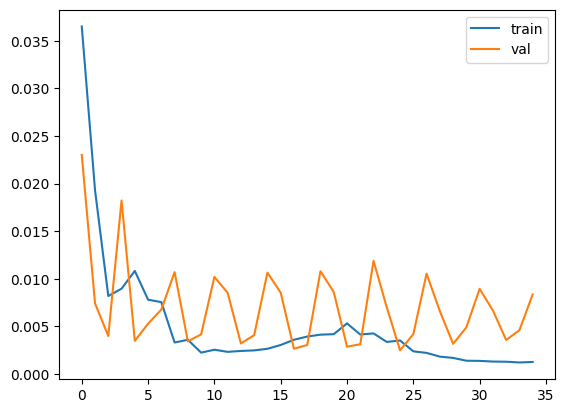

4/4 [==============================] - 0s 5ms/step
mae: 1.657503093207465


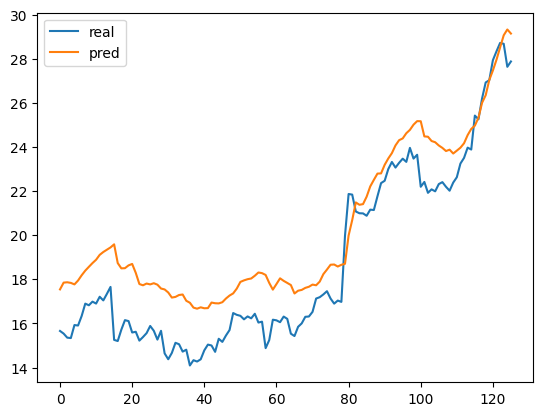

Epoch 1/1000
23/23 [==============================] - 2s 39ms/step - loss: 0.0252 - val_loss: 0.0373
Epoch 2/1000
23/23 [==============================] - 1s 36ms/step - loss: 0.0286 - val_loss: 0.0085
Epoch 3/1000
23/23 [==============================] - 1s 33ms/step - loss: 0.0177 - val_loss: 0.0046
Epoch 4/1000
23/23 [==============================] - 1s 34ms/step - loss: 0.0166 - val_loss: 0.0110
Epoch 5/1000
23/23 [==============================] - 1s 34ms/step - loss: 0.0116 - val_loss: 0.0193
Epoch 6/1000
23/23 [==============================] - 1s 34ms/step - loss: 0.0131 - val_loss: 0.0041
Epoch 7/1000
23/23 [==============================] - 1s 35ms/step - loss: 0.0036 - val_loss: 0.0073
Epoch 8/1000
23/23 [==============================] - 1s 34ms/step - loss: 0.0032 - val_loss: 0.0126
Epoch 9/1000
23/23 [==============================] - 1s 34ms/step - loss: 0.0021 - val_loss: 0.0114
Epoch 10/1000
23/23 [==============================] - 1s 34ms/step - loss: 0.0020 - val_lo

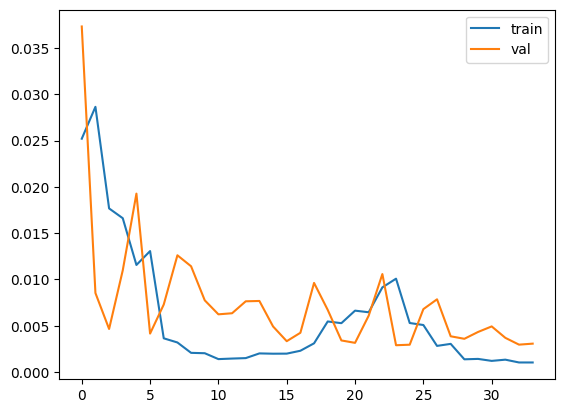

4/4 [==============================] - 0s 4ms/step
mae: 0.9903021659923736


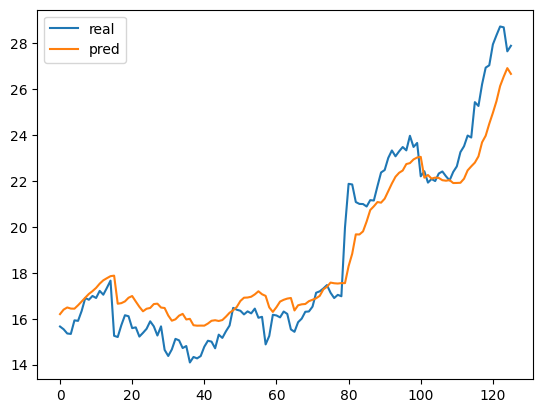

Epoch 1/1000
26/26 [==============================] - 2s 41ms/step - loss: 0.0217 - val_loss: 0.0358
Epoch 2/1000
26/26 [==============================] - 1s 34ms/step - loss: 0.0286 - val_loss: 0.0818
Epoch 3/1000
26/26 [==============================] - 1s 33ms/step - loss: 0.0372 - val_loss: 0.0293
Epoch 4/1000
26/26 [==============================] - 1s 33ms/step - loss: 0.0303 - val_loss: 0.0064
Epoch 5/1000
26/26 [==============================] - 1s 35ms/step - loss: 0.0195 - val_loss: 0.0049
Epoch 6/1000
26/26 [==============================] - 1s 34ms/step - loss: 0.0122 - val_loss: 0.0234
Epoch 7/1000
26/26 [==============================] - 1s 33ms/step - loss: 0.0147 - val_loss: 0.0066
Epoch 8/1000
26/26 [==============================] - 1s 34ms/step - loss: 0.0049 - val_loss: 0.0052
Epoch 9/1000
26/26 [==============================] - 1s 36ms/step - loss: 0.0047 - val_loss: 0.0069
Epoch 10/1000
26/26 [==============================] - 1s 33ms/step - loss: 0.0024 - val_lo

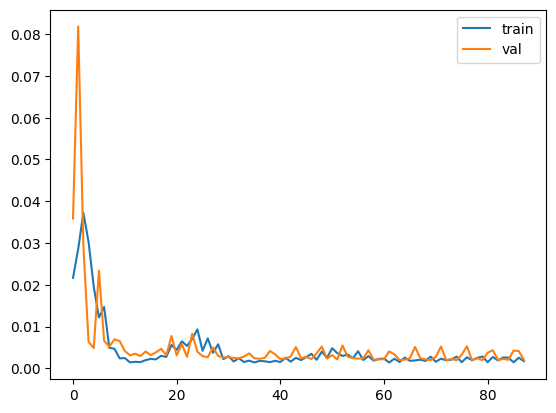

4/4 [==============================] - 0s 4ms/step
mae: 0.555630344285753


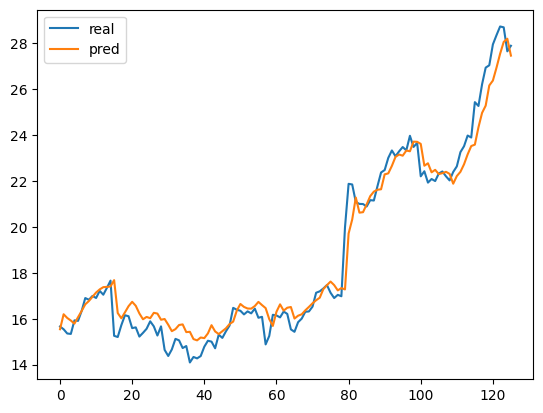

Epoch 1/1000
29/29 [==============================] - 2s 41ms/step - loss: 0.0371 - val_loss: 0.0129
Epoch 2/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0272 - val_loss: 0.0515
Epoch 3/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0380 - val_loss: 0.0178
Epoch 4/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0143 - val_loss: 0.0042
Epoch 5/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0183 - val_loss: 0.0096
Epoch 6/1000
29/29 [==============================] - 1s 32ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 7/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0067 - val_loss: 0.0107
Epoch 8/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0076 - val_loss: 0.0057
Epoch 9/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 10/1000
29/29 [==============================] - 1s 32ms/step - loss: 0.0048 - val_lo

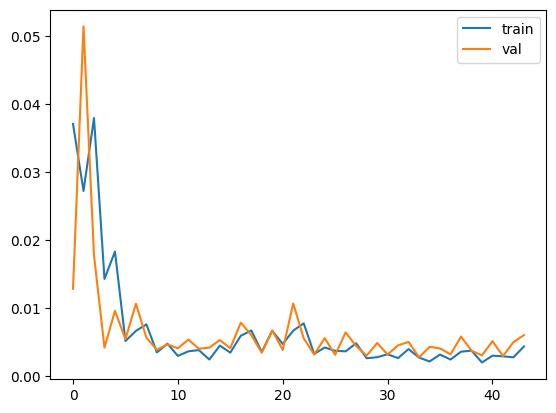

4/4 [==============================] - 0s 5ms/step
mae: 0.7436746092107862


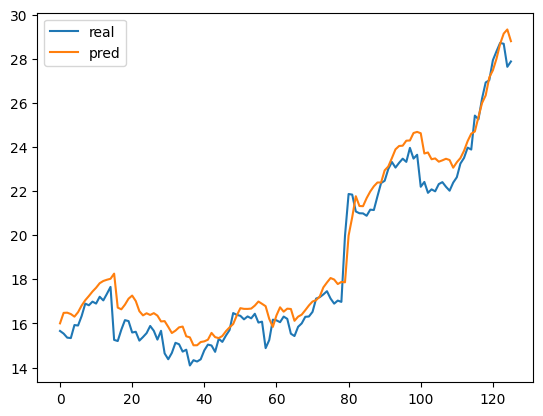

Epoch 1/1000
32/32 [==============================] - 2s 39ms/step - loss: 0.0444 - val_loss: 0.0074
Epoch 2/1000
32/32 [==============================] - 1s 35ms/step - loss: 0.0344 - val_loss: 0.1002
Epoch 3/1000
32/32 [==============================] - 1s 35ms/step - loss: 0.0389 - val_loss: 0.0855
Epoch 4/1000
32/32 [==============================] - 1s 35ms/step - loss: 0.0127 - val_loss: 0.0093
Epoch 5/1000
32/32 [==============================] - 1s 35ms/step - loss: 0.0218 - val_loss: 0.0015
Epoch 6/1000
32/32 [==============================] - 1s 34ms/step - loss: 0.0091 - val_loss: 0.0029
Epoch 7/1000
32/32 [==============================] - 1s 35ms/step - loss: 0.0086 - val_loss: 0.0097
Epoch 8/1000
32/32 [==============================] - 1s 34ms/step - loss: 0.0137 - val_loss: 0.0391
Epoch 9/1000
32/32 [==============================] - 1s 34ms/step - loss: 0.0093 - val_loss: 0.0217
Epoch 10/1000
32/32 [==============================] - 1s 34ms/step - loss: 0.0032 - val_lo

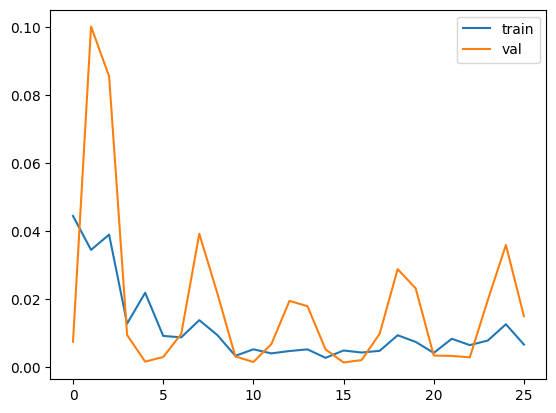

4/4 [==============================] - 0s 4ms/step
mae: 1.9453328047553164


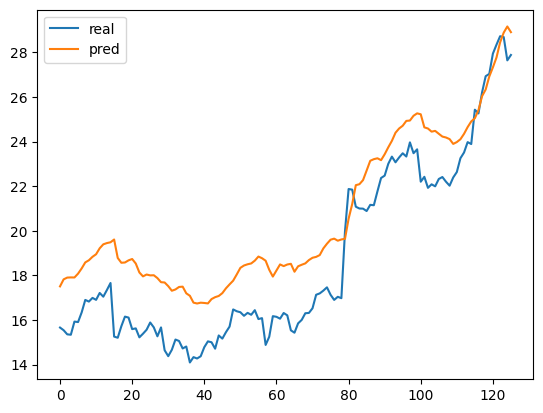

In [110]:
tscv = TimeSeriesSplit(n_splits=10)
maes=[]
y_test=np.repeat(y_test,X_train.shape[2],axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=10)
    X_t, X_v = X_train[train_index],X_train[val_index]
    y_t, y_v = y_train[train_index], y_train[val_index]
    model = tuner.hypermodel.build(best_hps)
    history=model.fit(X_t,y_t,epochs=1000,validation_data=(X_v,y_v),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape

    pred=np.repeat(y_pred,X_train.shape[2],axis=1)

    pred=scaler.inverse_transform(pred)[:,-1]
    
    mae=np.mean(np.abs(pred-y_test))
    maes.append(mae)
    print('mae:',mae)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()


In [111]:
model.summary()


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_33 (Bidirect  (None, 256)               112896    
 ional)                                                          
                                                                 
 dense_33 (Dense)            (None, 1)                 257       
                                                                 
Total params: 113153 (442.00 KB)
Trainable params: 113153 (442.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [112]:
average_mae=np.mean(maes)

print('average mae:',average_mae)

average mae: 1.6088470579143224
